## Empirical Analysis

Statistical techniques used : Vector Autoregression, Impulse Response Functions and Forecast Error Vector Decompositon

Focus is on the measures of labor utilization and inflation which are:

1. U1 Rate - Persons Unemployed 15 weeks or longer, as a percent of the civilian labor force
2. U2 Rate - Unemployment Rate: Job Losers
3. U3 Unemployment rate (urate)
4. U4 Rate - Total Unemployed Plus Discouraged Workers, as a Percent of the Civilian Labor Force Plus Discouraged Workers
5. U5 Rate - Special Unemployment Rate: Unemployed and Marginally Attached Workers
6. U6 Rate - Total unemployed, plus all marginally attached workers plus total employed part time for economic 
7. Prime Age Employment to Population Ratio: 25-54 years (PEPOP)


In [26]:
# Import necessary modules
import numpy as np
import pandas as pd 
from matplotlib import pyplot
import matplotlib.pyplot as plt  # For plotting graphs 
%matplotlib inline

# standardizes the size of all plots, rather than typing plot(figsize = (12,6)) everytime
from pylab import rcParams
rcParams['figure.figsize'] = 12,6 

from scipy import stats
from datetime import datetime
from functools import reduce
import datetime
import quandl

from statsmodels.tsa.stattools import coint # perform Johansen cointegration test
import statsmodels.api as sm # to make regressions 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import scipy.stats as sp # SciPy for linear regression.

quandl.ApiConfig.api_key = '-kesKc4A8jkkBwyX3rSX'

In [17]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# imported the relavant macroecon variables

data = quandl.get(["FRED/ANFCI", # Chicago Fed National Financial Condition Index
                   "FRED/T10YFF", # 10 year Treasury - FFR
                   "FRED/T1YFFM", # 1 year Treasury - FFR
                   
                   "FRED/FEDFUNDS", # Federal Funds Rate
                   "UMICH/SOC1", # UMich: Consumer Sentiment Index
                   "FRED/RECPROUSM156N", # Smoothed U.S. Recession Probabilities
                   "FRED/GDPC1", # Real GDP
                   "FRED/INDPRO", # Industrial Production Index
                   "FRED/WALCL", # Total Assets (Less Eliminations From Consolidation)
                   "FRED/LNS12300060", # Employment to population ratio: 25-54 Yrs
                   
                   "FRED/RPONTSYD", # Overnight Repurchase Agreements: Treasury Securities Purchased by Fed in OMO
                   "FRED/AHETPI", # Average Hourly Earnings for Production & Nonsupervisory Employees
                   "FRED/CPIAUCSL", # CPI
                   "FRED/PSAVERT", # Personal Savings Rate
                   "FRED/CCSA", # UI claims 
                   "FRED/THREEFF4", # Fitted Instantaneous Forward Rate 4 Years Hence
                   "FRED/DGS1", # 1-Year Treasury Constant Maturity Rate
                   "FRED/T5YIE", # 5-Year Breakeven Inflation Rate
                   "FRED/T5YIFRM", # 5-Year, 5-Year Forward Inflation Expectation Rate
                   
                   "FRED/U1RATE",
                   "FRED/U2RATE", 
                   "FRED/UNRATE",
                   "FRED/U4RATE",
                   "FRED/U5RATE",
                   "FRED/U6RATE"],
                  start_date="1978-01-01", end_date="2020-04-01",collapse = 'monthly',date_parser=parser)
data.tail()

,FRED/ANFCI - Value,FRED/T10YFF - Value,FRED/T1YFFM - Value,FRED/FEDFUNDS - Value,UMICH/SOC1 - Index,FRED/RECPROUSM156N - Value,FRED/GDPC1 - Value,FRED/INDPRO - Value,FRED/WALCL - Value,FRED/LNS12300060 - Value,...,FRED/THREEFF4 - Value,FRED/DGS1 - Value,FRED/T5YIE - Value,FRED/T5YIFRM - Value,FRED/U1RATE - Value,FRED/U2RATE - Value,FRED/UNRATE - Value,FRED/U4RATE - Value,FRED/U5RATE - Value,FRED/U6RATE - Value
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,-0.66,0.37,0.00,1.55,99.3,12.55,NaN,109.6357,4165591.0,80.4,...,1.6523,1.59,1.68,1.81,1.2,1.6,3.5,3.7,4.2,6.7
2020-01-31,-0.70,-0.08,-0.02,1.55,99.8,25.98,18974.702,109.1337,4151630.0,80.6,...,1.1946,1.45,1.60,1.79,1.2,1.6,3.6,3.8,4.4,6.9
2020-02-29,-0.50,-0.45,-0.17,1.58,101.0,57.32,NaN,109.2569,4158637.0,80.5,...,0.7941,0.97,1.33,1.65,1.2,1.7,3.5,3.8,4.4,7.0
2020-03-31,0.43,0.62,-0.30,0.65,89.1,100.00,NaN,104.3262,5254278.0,79.6,...,0.4898,0.17,0.49,1.30,1.2,2.4,4.4,4.7,5.2,8.7
2020-04-30,NaN,0.56,0.13,0.05,NaN,100.00,NaN,92.5919,5811607.0,69.7,...,0.4332,0.16,0.56,1.45,1.1,13.2,14.7,15.1,16.0,22.8


In [18]:
data.columns = ['FRED/ANFCI - Value', 'FRED/T10YFF - Value', 'FRED/T1YFFM - Value', 'FRED/FEDFUNDS - Value', 
                'UMICH/SOC1 - Index', 'FRED/RECPROUSM156N - Value', 'FRED/GDPC1 - Value', 'FRED/INDPRO - Value',
                'FRED/WALCL- Value', 'FRED/LNS12300060 - Value', 'FRED/RPONTSYD - Value', 'FRED/AHETPI - Value',
                'FRED/CPIAUCSL - Value', 'FRED/PSAVERT - Value', 'FRED/CCSA - Value', 'FRED/THREEFF4 - Value',
                'FRED/DGS1 - Value','FRED/T5YIE - Value', 'FRED/T5YIFRM - Value', 'FRED/U1RATE - Value', 
                'FRED/U2RATE - Value','FRED/UNRATE - Value','FRED/U4RATE - Value','FRED/U5RATE - Value',
                'FRED/U6RATE - Value']

# rename the columns
data.rename(columns={'FRED/ANFCI - Value': 'FCI',
                     'FRED/T10YFF - Value': '10yrtre-ffr',
                     'FRED/T1YFFM - Value': '1yrtre-ffr',
                     'FRED/FEDFUNDS - Value': 'fed_fundsR',
                     'UMICH/SOC1 - Index': 'CSI',
                     'FRED/RECPROUSM156N - Value': 'rec_prob',
                     'FRED/GDPC1 - Value': 'real_GDP',
                     'FRED/INDPRO - Value': 'IPI',
                     'FRED/WALCL- Value': "total_assets",
                     'FRED/LNS12300060 - Value': 'pepop',
                     'FRED/RPONTSYD - Value': 'repo_purchFed',
                     'FRED/AHETPI - Value': 'hour_earn', 
                     'FRED/CPIAUCSL - Value': 'CPI',
                     'FRED/PSAVERT - Value': 'PSR',
                     'FRED/CCSA - Value': 'UI_claims',
                     'FRED/THREEFF4 - Value':'4forwardR',
                     'FRED/DGS1 - Value': '1yr_trR',
                    'FRED/T5YIE - Value': '5break_infR',
                    'FRED/T5YIFRM - Value': '5yr-5forward_infexpR',
                     
                    'FRED/U1RATE - Value': 'u1rate',
                    'FRED/U2RATE - Value': 'u2rate',
                    'FRED/U4RATE - Value': 'u4rate',
                    'FRED/U5RATE - Value': 'u5rate',
                    'FRED/U6RATE - Value': 'u6rate',
                    'FRED/UNRATE - Value': 'unrate'}, inplace=True)
data.head()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,real_GDP,IPI,total_assets,pepop,...,4forwardR,1yr_trR,5break_infR,5yr-5forward_infexpR,u1rate,u2rate,unrate,u4rate,u5rate,u6rate
Date,,,,,,,,,,,,,,,,,,,,,
1978-01-31,-0.76,1.15,0.58,6.70,83.7,10.45,6329.791,49.2066,NaN,73.0,...,NaN,7.26,NaN,NaN,1.6,2.8,6.4,NaN,NaN,NaN
1978-02-28,-0.69,1.21,0.56,6.78,84.3,0.15,NaN,49.4502,NaN,73.2,...,NaN,7.32,NaN,NaN,1.6,2.7,6.3,NaN,NaN,NaN
1978-03-31,-0.24,1.18,0.52,6.79,78.8,0.00,NaN,50.3928,NaN,73.3,...,NaN,7.48,NaN,NaN,1.5,2.6,6.3,NaN,NaN,NaN
1978-04-30,0.15,0.99,0.56,6.89,81.6,0.00,6574.390,51.4368,NaN,73.5,...,NaN,7.70,NaN,NaN,1.5,2.6,6.1,NaN,NaN,NaN
1978-05-31,0.23,0.99,0.46,7.36,82.9,0.15,NaN,51.6276,NaN,73.4,...,NaN,7.94,NaN,NaN,1.4,2.5,6.0,NaN,NaN,NaN


In [19]:
# since the Real GDP is quarterly, I have used a spline interpolation method to convert into monthly data
inter_realGDP = data['real_GDP'].interpolate(method='spline', order =3)
inter_realGDP.tail(10)

Date
2019-07-31    19121.112000
2019-08-31    19167.056109
2019-09-30    19205.200335
2019-10-31    19221.970000
2019-11-30    19200.670650
2019-12-31    19123.813367
2020-01-31    18974.702000
2020-02-29    18755.093966
2020-03-31    18418.913945
2020-04-30    17978.472195
Name: real_GDP, dtype: float64

In [20]:
merged = pd.merge(data, inter_realGDP, on = 'Date') # merged the interpolated GDP data with the rest of the dataset

merged1 = merged.drop('real_GDP_x', axis =1).rename(columns={'real_GDP_y': 'inter_realGDP'}) 
merged1.drop(merged1.tail(1).index,inplace= True)# drop the last row with missing values as it contains NaN

merged1['real_wage'] = merged1['hour_earn']/merged1['CPI'] # Add a column that calculates the real wage
#merged1.head()

In [21]:
# Calculates the percent change of all the variables
change = merged1.pct_change()
#change.head()

In [22]:
# drops rows with NaN values, and replaces inf values with 0
short = change.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
short.head()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,IPI,total_assets,pepop,repo_purchFed,...,5break_infR,5yr-5forward_infexpR,u1rate,u2rate,unrate,u4rate,u5rate,u6rate,inter_realGDP,real_wage
Date,,,,,,,,,,,,,,,,,,,,,
2003-02-28,0.102564,-0.108614,-0.666667,0.016129,-0.030340,9.000000,0.001422,0.012866,0.000000,0.423729,...,0.174497,0.018868,0.000000,0.031250,0.017241,0.016393,0.014706,0.020202,0.002056,-0.000872
2003-03-31,0.139535,0.029412,-1.250000,-0.007937,-0.028786,0.200000,-0.002314,0.004209,0.001267,-0.828571,...,-0.057143,-0.050926,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009901,0.002794,-0.002937
2003-04-30,0.285714,0.053061,-2.000000,0.008000,0.108247,-0.166667,-0.007149,0.029344,0.001266,7.819444,...,-0.121212,-0.029268,0.045455,0.000000,0.016949,0.016129,0.014493,0.020000,0.003729,0.004478
2003-05-31,0.095238,-0.189922,-9.000000,0.000000,0.070930,-0.900000,0.000280,-0.001873,-0.002528,-1.000000,...,-0.131034,-0.005025,0.000000,0.060606,0.016667,0.015873,0.014286,-0.009804,0.005285,0.004918
2003-07-31,0.000000,0.650718,-1.523810,-0.172131,0.013378,0.600000,0.004403,-0.005004,-0.001267,0.000000,...,0.206897,0.166667,0.041667,0.000000,-0.015873,-0.030303,-0.013889,0.000000,0.005808,-0.000671


In [23]:
short.info() # after dropping the missing values, the dataset truncates to 150 rows

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2003-02-28 to 2020-03-31
Data columns (total 26 columns):
FCI                     150 non-null float64
10yrtre-ffr             150 non-null float64
1yrtre-ffr              150 non-null float64
fed_fundsR              150 non-null float64
CSI                     150 non-null float64
rec_prob                150 non-null float64
IPI                     150 non-null float64
total_assets            150 non-null float64
pepop                   150 non-null float64
repo_purchFed           150 non-null float64
hour_earn               150 non-null float64
CPI                     150 non-null float64
PSR                     150 non-null float64
UI_claims               150 non-null float64
4forwardR               150 non-null float64
1yr_trR                 150 non-null float64
5break_infR             150 non-null float64
5yr-5forward_infexpR    150 non-null float64
u1rate                  150 non-null float64
u2rate               

Graph of measure of inflation (real wage growth) vs measure of employment (prime age employment to population ratio)

While it apprears that they may be weekly positively correlated as they almost move in tandem with each other in several time periods; however, they are weekly negative correlated and stationary.

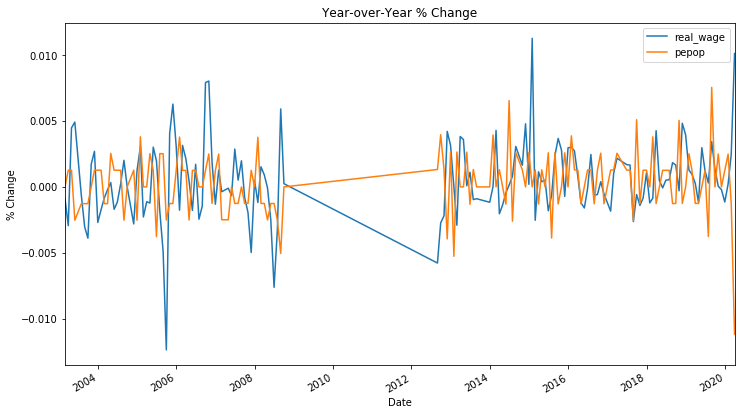

In [24]:
ax = short[['real_wage', 'pepop']].plot(figsize=(12,7),
                                            xlim=['2003-02-28','2020-03-31'], title='Year-over-Year % Change')
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='% Change');

In [25]:
short[['real_wage', 'pepop']].corr() # slightly negatively correlated and stationary variables

,real_wage,pepop
real_wage,1.000000,-0.130632
pepop,-0.130632,1.000000


In [26]:
data_list = short[['10yrtre-ffr', '1yrtre-ffr', 'fed_fundsR', 'CSI', 'rec_prob', 'IPI','pepop', 'PSR',
               'UI_claims', 'inter_realGDP', 'real_wage', 'total_assets', 'repo_purchFed','4forwardR', '1yr_trR',
                  '5break_infR', '5yr-5forward_infexpR', 'unrate', 'u1rate', 'u2rate', 'u4rate', 'u5rate', 'u6rate']]

## Augmented Dickey Fuller Test to check for Stationarity

The series with unit root are: percent changes in the following variables:
UI Claims, 1 year maturity Treasury rate, and real GDP

In [12]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for stationarity of a given series and print report"""
    
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    # print sumamry
    print(f'     Augmented Dickey-Fuller Test on "{name}"', "\n    ", '-'*47)
    print(f'  Null Hypothesis: Data has unit too. Non-Stationary.')
    print(f'  Significance Level    = {signif}')
    print(f'  Test Statistic        = {output["test_statistic"]}')
    print(f'  No. of Lags Chosen    = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f'  Critical Value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting null hypothesis.")
          print(f" => Series is stationary.")
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is non-stationary.")
 

In [27]:
         
     # ADF Test on each column
for name, column in data_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "10yrtre-ffr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -13.8862
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.475
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "1yrtre-ffr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -11.1003
  No. of Lags Chosen    = 0
  Critical Value 1%     = -3.475
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "fed_fundsR" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Sta

In [25]:
# stationarizes the 4 variables by differencing, and concats them with the dataset
short1 = short[['UI_claims','1yr_trR','inter_realGDP', 'u4rate']].diff().add_suffix("_diff")
stat = pd.concat([short, short1], axis=1)

# drops rows with NaN values, and replaces inf values with 0
stat1 = stat.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
stat1.tail()

In [35]:
stat1.tail()

,FCI,10yrtre-ffr,1yrtre-ffr,fed_fundsR,CSI,rec_prob,IPI,total_assets,pepop,repo_purchFed,...,unrate,u4rate,u5rate,u6rate,inter_realGDP,real_wage,UI_claims_diff,1yr_trR_diff,inter_realGDP_diff,u4rate_diff
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-30,-0.028571,1.000000,-1.090909,-0.153005,0.013613,0.153846,0.009280,0.008222,0.000000,0.113362,...,-0.027778,-0.026316,0.000000,-0.014493,-0.001108,-0.000208,0.004717,0.171466,-0.001981,-0.053343
2019-12-31,-0.029412,0.681818,-1.000000,0.000000,0.025826,12.944444,-0.003663,0.027811,0.001245,-0.752234,...,0.000000,0.000000,-0.023256,-0.014706,-0.004003,-0.001142,0.041168,-0.052002,-0.002895,0.026316
2020-01-31,0.060606,-1.216216,0.000000,0.000000,0.005035,1.070120,-0.004579,-0.003352,0.002488,0.849311,...,0.028571,0.027027,0.047619,0.029851,-0.007797,0.000223,-0.056512,-0.081800,-0.003794,0.027027
2020-02-29,-0.285714,4.625000,7.500000,0.019355,0.012024,1.206313,0.001129,0.001688,-0.001241,-0.709595,...,-0.027778,0.000000,0.000000,0.014493,-0.011574,0.002459,-0.018410,-0.242984,-0.003777,-0.027027
2020-03-31,-1.860000,-2.377778,0.764706,-0.588608,-0.117822,0.744592,-0.045129,0.263462,-0.011180,-0.960317,...,0.257143,0.236842,0.181818,0.242857,-0.017925,0.010121,3.413382,-0.493708,-0.006351,0.236842


In [30]:
stat_list = stat1[['UI_claims_diff','1yr_trR_diff','inter_realGDP_diff', 'u4rate_diff']]

# ADF Test on each column
for name, column in stat_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "UI_claims_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -3.8565
  No. of Lags Chosen    = 1
  Critical Value 1%     = -3.476
  Critical Value 5%     = -2.881
  Critical Value 10%    = -2.577
 => P-Value = 0.0024. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "1yr_trR_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -4.4594
  No. of Lags Chosen    = 12
  Critical Value 1%     = -3.479
  Critical Value 5%     = -2.883
  Critical Value 10%    = -2.578
 => P-Value = 0.0002. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "inter_realGDP_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has

After differencing, the differeced values of percent change in UI claims, constant 1 year Treasury maturity securities, and real GDP are stationary.

## Autocorrelation Plots

These are the ACFs of two of the three variables with unit root

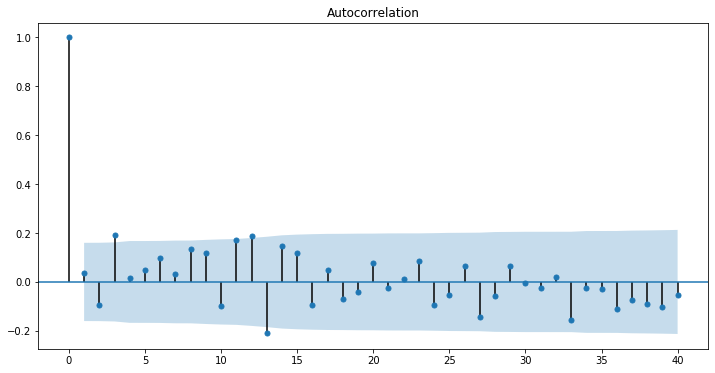

In [28]:
# makes the ACF plot
plot_acf(short['1yr_trR'], lags = 40)
# the plots show strong autocorrelation of lags as spikes gradually reduce, instead of plumeting to 0.
pyplot.show()

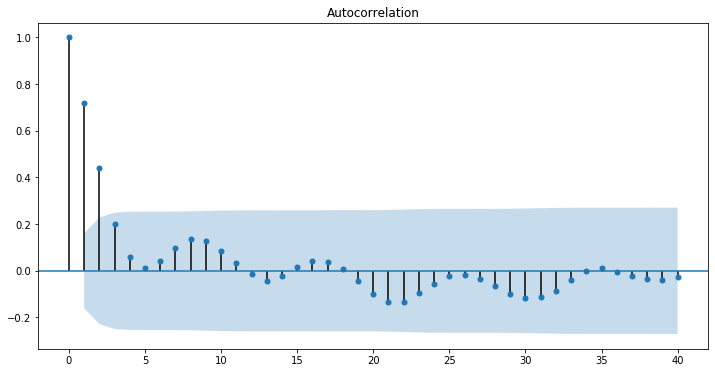

In [29]:
plot_acf(short['inter_realGDP'], lags = 40)
pyplot.show()

## Vector Autoregression Model (VAR)

As a reduced form model, VAR's coefficients are hard to interpret. Instead, we canconstruct the impulse-response functions (IRF) and forecast error variance decomposition (FEVD) to gauge how the variables affect each other.

In [50]:
model1 = VAR(stat1[['pepop','unrate','u1rate', 'u2rate', 'u4rate_diff', 'u5rate', 'u6rate', 'fed_fundsR']])
results1 = model1.fit(2)
results1.summary()

/Users/sudikshajoshi/anaconda3/envs/TSA_COURSE/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jun, 2020
Time:                     08:46:58
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -59.8855
Nobs:                     147.000    HQIC:                  -61.5280
Log likelihood:           3072.26    FPE:                6.22486e-28
AIC:                     -62.6521    Det(Omega_mle):     2.59369e-28
--------------------------------------------------------------------
Results for equation pepop
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000211         0.000199            1.061           0.288
L1.pepop              -0.335369         0.097043           -3.456           0.001
L1.unrate              0.035391         0.016300        

## Impulse Response Functions

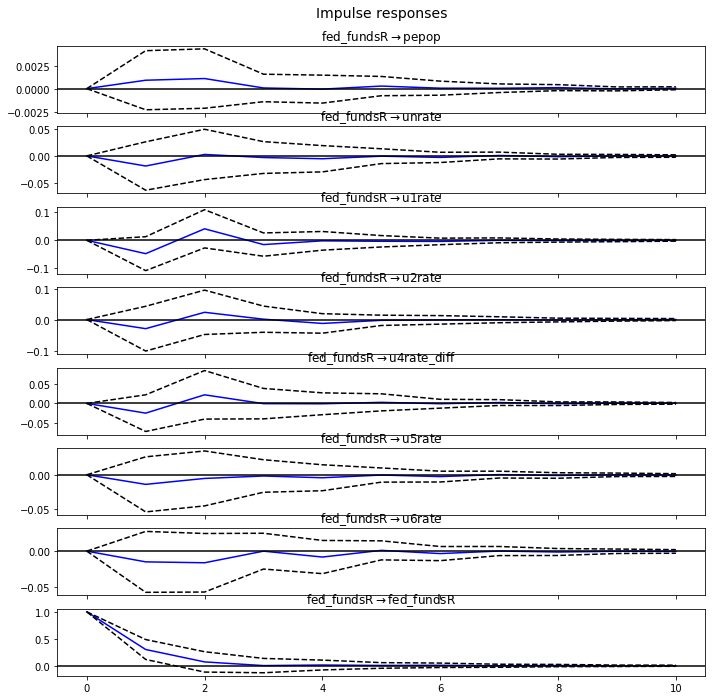

In [51]:
irf1 = results1.irf(10)
irf1.plot(impulse='fed_fundsR');

When there is a positive shock of federal funds rate on the changes in pepop, the percent change in ISI boosts by around 0.001 units and flattens at that level for 2 periods. After that, it gradually descends linearly until the affect of the shock attentuates and dissipates after the 3rd period.

On the contrary, all other labor utilization shocks face a negative impact from change in federal funds rate. From the IRFs, u5rate appears to have minimal shock impact, than u1rate has as it plunges to the negative territory by 0.05 in period 1, then rises by 0.1 units to the 0.05 level in period 2. Thereafter, it converges to the steady state level.

## Forecast Error Vector Decomposition (FEVD)

In [52]:
fevd = results1.fevd(5) # forecast period is 5 year=> forecasting upto 5 years into the future
fevd.summary()

FEVD for pepop
        pepop    unrate    u1rate    u2rate  u4rate_diff    u5rate    u6rate  fed_fundsR
0    1.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000    0.000000
1    0.939035  0.009213  0.011019  0.009529     0.012345  0.015299  0.001430    0.002131
2    0.882839  0.052350  0.017390  0.011100     0.012538  0.017268  0.001692    0.004823
3    0.859375  0.051333  0.025919  0.012434     0.016254  0.021200  0.008864    0.004621
4    0.839310  0.054455  0.025320  0.017480     0.015897  0.033895  0.009125    0.004519

FEVD for unrate
        pepop    unrate    u1rate    u2rate  u4rate_diff    u5rate    u6rate  fed_fundsR
0    0.179961  0.820039  0.000000  0.000000     0.000000  0.000000  0.000000    0.000000
1    0.170486  0.684991  0.005630  0.028667     0.037368  0.009462  0.059105    0.004291
2    0.154295  0.660068  0.011003  0.029056     0.033943  0.053302  0.054370    0.003964
3    0.161115  0.630553  0.017873  0.032572     0.032901  0.067170  0.053933  

Whilst impulse response functions delineate the impact of a shock to one endogenous variable on to the other variables in the VAR, a FEVD distinguishes the variation present in an endogenous variable into the component shocks to the VAR.

Variance decomposition shows how much a shock to one variable (e.g: pct change in U2 rate, unemployment rate, etc) impacts the variance of the forecast error of a different one (e.g: prime age population to employment ratio, U5 rate). So, in the short run, i.e. in the same period, the U6 rate itself explains 27.29% of the variance in its forecast error. The percent change in the following variables - u2rate, u5rate and fed_fundsR are strongly exogenous as they only weakly influence in predicting the u6rate in the present. But precent change in unrate explains 45.64 percent of variance in the error of u6rate (percent change), indicating that it is strongly endogenous as it has a strong influence on u6rate. 

However, in the long run, the influence of percent change in u6rate in explaining the variance in its forecast error has diminished from 27.29 to 21.95 percent, whereas other variables such as percent change in u1rate, u2rate, u5rate and fed_fundsR have an incremental influence, than they had in the short in the earlier periods in the short run. 

In [58]:
import statsmodels.api as sm # import statsmodels 
X = stat1['fed_fundsR']
y = stat1['u6rate']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 u6rate   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     20.92
Date:                Thu, 11 Jun 2020   Prob (F-statistic):           1.01e-05
Time:                        09:58:17   Log-Likelihood:                 322.16
No. Observations:                 149   AIC:                            -640.3
Df Residuals:                     147   BIC:                            -634.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.283      0.778      -0.005       0.004
fed_fundsR    -0.0804      0.018     -4.574      0.000      -0.115      -0.046
==============================================================================
Omnibus:                      103.999   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1665.459
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      18.810   Cond. No.                         7.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model = VAR(short[['IPI','pepop', 'PSR', 'real_wage', 'total_assets', 'repo_purchFed']])
results = model.fit(2)
results.summary()

/Users/sudikshajoshi/anaconda3/envs/TSA_COURSE/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jun, 2020
Time:                     07:00:43
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -32.4579
Nobs:                     148.000    HQIC:                  -33.3957
Log likelihood:           1336.76    FPE:                1.65532e-15
AIC:                     -34.0375    Det(Omega_mle):     9.98843e-16
--------------------------------------------------------------------
Results for equation IPI
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.000447         0.000687           -0.651           0.515
L1.IPI                   0.175700         0.112775            1.558           0.119
L1.pepop                 0.578985         0.297252

## Impulse Response Functions (IRF)

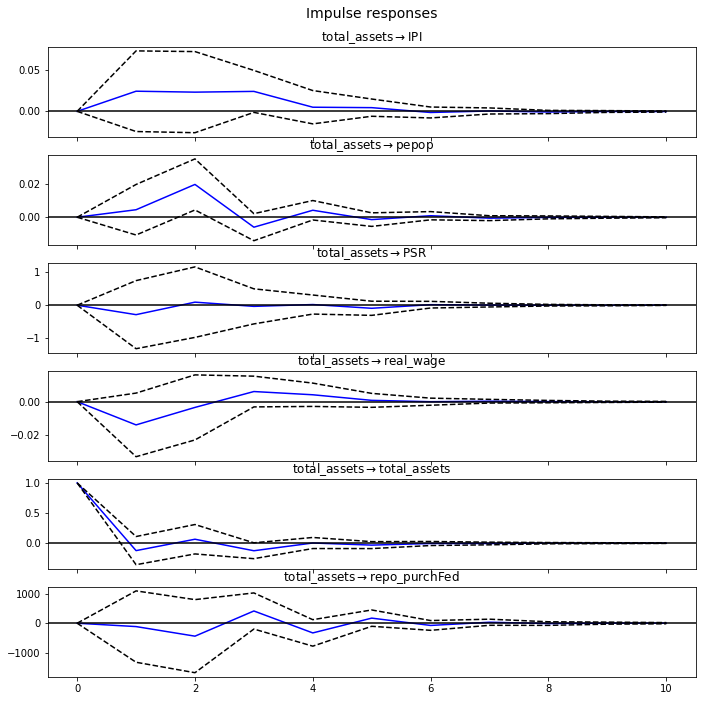

In [32]:
irf = results.irf(10)
irf.plot(impulse='total_assets');

When there is a positive shock of the total assets on the changes in industrial production index (IPI) i.e. when the Fed buys more total assets than normally would, the percent change in ISI boosts by slightly less than 0.025 units and flattens at that level from 1 to 2.5 periods. After that, it gradually descends linearly until the affect of the sock attentuates and dissipates after the 6th period. 

Similary, on applying a positive shock, the percent change in pepop ratio rises and reaches the peak in period 2, after which is tumbles down to the negative territory. Thereafter, the ratio approaches the steady state level.

The percent change in wage or wage growth initially react negatively, wherein it reaches the nadir at about -0.018 in period 1.5, and then pushes back up the orginal level of wage growth. There is a modicum of increase - slightly above 0 unit, after which it reduces to its steady state level.

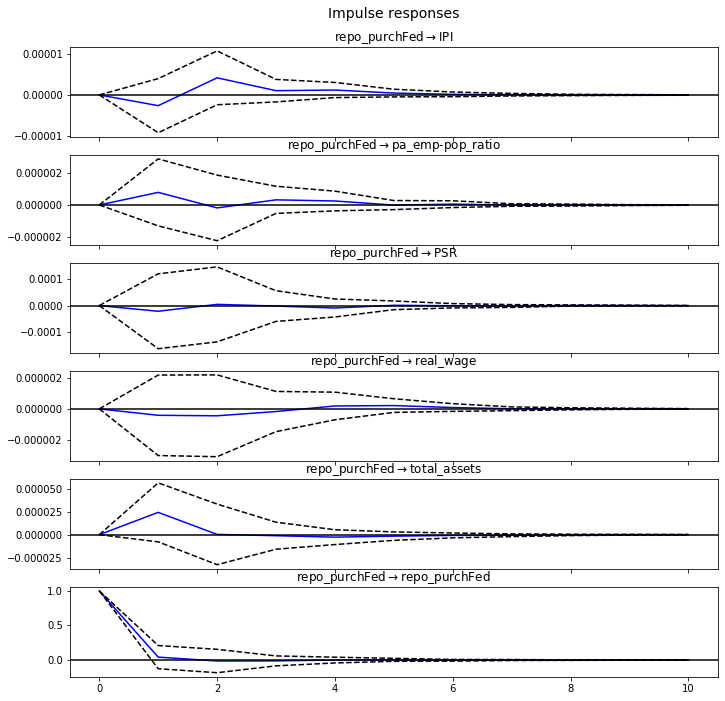

In [174]:
irf.plot(impulse='repo_purchFed');

As the Fed accerleates the monetary shock by buying more overnight repurchase agreements from the open market operations, there are hardly any conspicuous changes in the growth of personal savings rate. It mildly diminishes, and then reverts back to 0 after period 2, converging to the steady state level 5th period onwards. 

## Forecast Error Variance Decomposition (FEVD)

In [33]:
fevd = results.fevd(5)
fevd.summary()

FEVD for IPI
          IPI     pepop       PSR  real_wage  total_assets  repo_purchFed
0    1.000000  0.000000  0.000000   0.000000      0.000000       0.000000
1    0.952830  0.022506  0.003261   0.011376      0.006059       0.003968
2    0.923619  0.021586  0.013044   0.015473      0.012651       0.013627
3    0.916932  0.021452  0.012960   0.015493      0.019058       0.014104
4    0.915344  0.021958  0.012949   0.015471      0.019357       0.014921

FEVD for pepop
          IPI     pepop       PSR  real_wage  total_assets  repo_purchFed
0    0.091826  0.908174  0.000000   0.000000      0.000000       0.000000
1    0.094655  0.894323  0.000220   0.004475      0.002763       0.003564
2    0.092963  0.847221  0.000314   0.010808      0.045132       0.003561
3    0.092539  0.842318  0.001593   0.010842      0.048572       0.004137
4    0.092034  0.836175  0.001910   0.015224      0.050239       0.004419

FEVD for PSR
          IPI     pepop       PSR  real_wage  total_assets  repo_purc

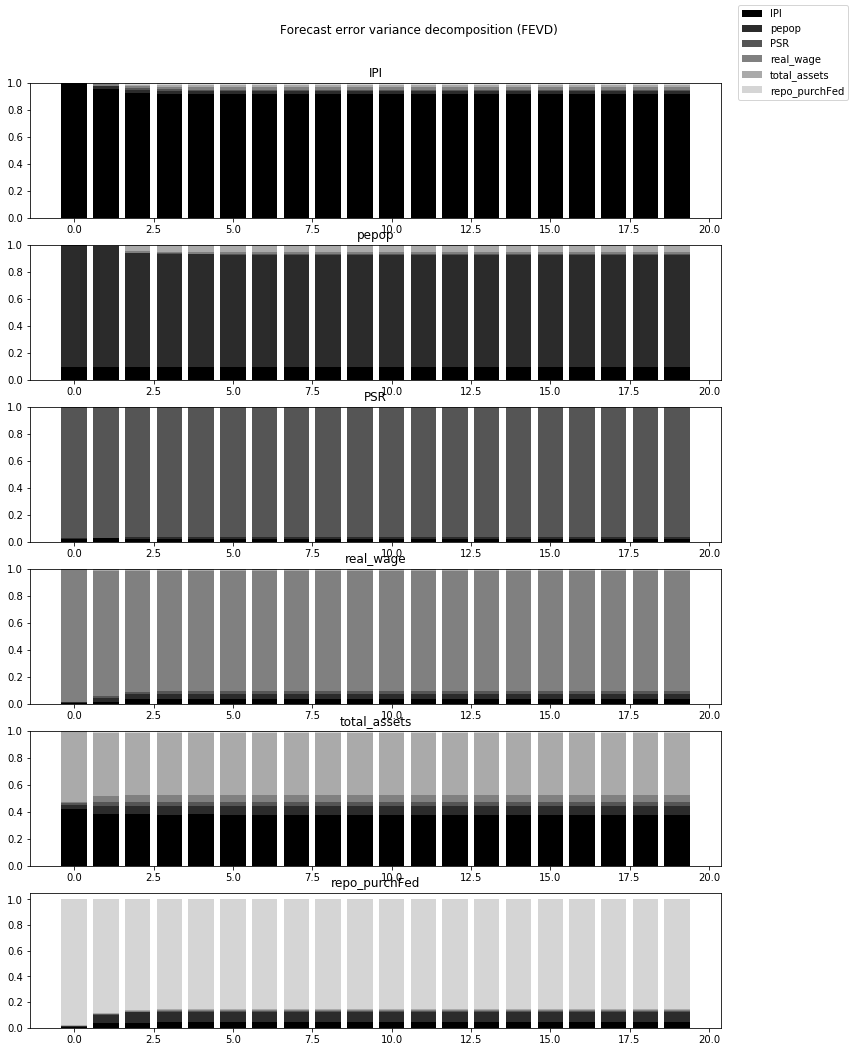

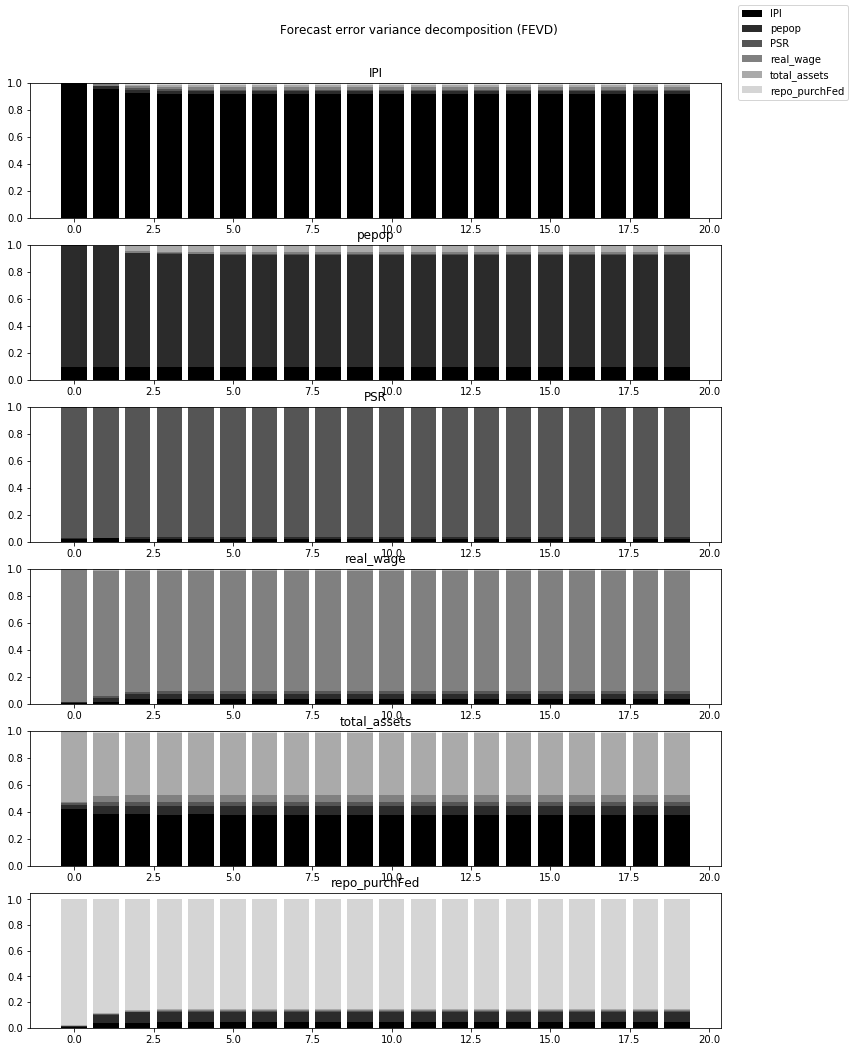

In [34]:
results.fevd(20).plot(figsize = (12,15))

Whilst impulse response functions delineate the impact of a shock to one endogenous variable on to the other variables in the VAR, a VECM distinguishes the variation present in an endogenous variable into the component shocks to the VAR.

Variance decomposition shows how much a shock to one variable (e.g: pct change in wage growth, personal savings rate) impacts the variance of the forecast error of a different one (e.g: pct change in prime age population to employment ratio, ISI). So, in the short run, i.e. in the same period, we can explain 98.84% of the variance in the forecast error of real wage growth by real wage growth itself. It is strongly exogenous as the percent change in pther variables - PSR, total assets, real wage, etc, only weakly influence in predicting the ISI in the future. 

However, in the long run, the influence of  percent change in ISI in explaining the variance in its forecast error has diminished from 98.84 to 88.71 percent. 

In [45]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# imported the relavant macroecon variables

labor = quandl.get([
                "FRED/LNS12300060", # Employment to population ratio: 25-54 Yrs
                "FRED/UNRATE" ,
                "FRED/ECIWAG", # Employment Cost Index (ECI)
"FRED/PCETRIM12M159SFRBDAL", # Trimmed mean PCE Inflation Rate (measured as % change from 1 year ago)
                "FRED/PCEPI", # PCE: Chain-type Price Index 
                 "FRED/CIVPART", # Civilian Labor Force Participation Rate
                 "FRED/FRBKCLMCIM"], # Kansas City labor Market Conditions Indicators (LMCI)
                  start_date="2001-01-01", end_date="2020-01-01",collapse = 'monthly',date_parser=parser)
labor.tail()

,FRED/LNS12300060 - Value,FRED/UNRATE - Value,FRED/ECIWAG - Value,FRED/PCETRIM12M159SFRBDAL - Value,FRED/PCEPI - Value,FRED/CIVPART - Value,FRED/FRBKCLMCIM - Value
Date,,,,,,,
2019-09-30,80.1,3.5,NaN,2.03,109.935,63.2,0.14408
2019-10-31,80.3,3.6,138.9,2.04,110.141,63.3,0.16931
2019-11-30,80.3,3.5,NaN,1.95,110.232,63.2,0.23276
2019-12-31,80.4,3.5,NaN,1.96,110.530,63.2,0.21979
2020-01-31,80.6,3.6,140.3,2.10,110.678,63.4,0.28336


In [46]:
labor.columns = ['FRED/LNS12300060 - Value','FRED/UNRATE - Value', 'FRED/ECIWAG - Value', 
                 'FRED/PCETRIM12M159SFRBDAL - Value','FRED/PCEPI - Value', 'FRED/CIVPART - Value',
                'FRED/FRBKCLMCIM - Value']

# rename the columns
labor.rename(columns={
                     'FRED/LNS12300060 - Value': 'pepop',
                    'FRED/UNRATE - Value': 'unrate',
                    'FRED/ECIWAG - Value': 'eciwag',
    'FRED/PCETRIM12M159SFRBDAL - Value': 'trimpce',
                     'FRED/PCEPI - Value': 'pceindex',
                   'FRED/CIVPART - Value': 'lfpr',
               'FRED/FRBKCLMCIM - Value': 'lmci'},inplace=True)
labor.tail()

,pepop,unrate,eciwag,trimpce,pceindex,lfpr,lmci
Date,,,,,,,
2019-09-30,80.1,3.5,NaN,2.03,109.935,63.2,0.14408
2019-10-31,80.3,3.6,138.9,2.04,110.141,63.3,0.16931
2019-11-30,80.3,3.5,NaN,1.95,110.232,63.2,0.23276
2019-12-31,80.4,3.5,NaN,1.96,110.530,63.2,0.21979
2020-01-31,80.6,3.6,140.3,2.10,110.678,63.4,0.28336


In [47]:
# since the Real GDP is quarterly, I have used a spline interpolation method to convert into monthly data
eci_inter = labor['eciwag'].interpolate(method='spline', order =3)
eci_inter.tail(10)

Date
2019-04-30    136.800000
2019-05-31    136.890560
2019-06-30    137.220545
2019-07-31    137.900000
2019-08-31    137.910865
2019-09-30    138.248979
2019-10-31    138.900000
2019-11-30    138.944819
2019-12-31    139.302776
2020-01-31    140.300000
Name: eciwag, dtype: float64

In [48]:
merge = pd.merge(labor, eci_inter.to_frame(), on = 'Date')
#labor.tail()

labor1 = merge.drop('eciwag_x', axis =1).rename(columns={'eciwag_y': 'eciwag'}) 

# 4 quarter (or 12 months) moving average of PCE Price Index
labor1['pceindex_ma12'] = labor1.iloc[:,3].rolling(window=12).mean() 

# calculate the percent change from 1 year (or 12 months ago) ago
labor2 = pd.concat([labor1, labor1[['pceindex','eciwag','pceindex_ma12']].pct_change(12).add_suffix("_change")], 
                   axis=1)
labor2.drop(labor2.head(23).index,inplace= True)# drop the first row with missing values as it contains NaN
labor2.head()

,pepop,unrate,trimpce,pceindex,lfpr,lmci,eciwag,pceindex_ma12,pceindex_change,eciwag_change,pceindex_ma12_change
Date,,,,,,,,,,,
2002-12-31,79.0,6.0,2.08,81.494,66.3,-0.58155,93.261549,80.789167,0.020985,0.036513,0.013185
2003-01-31,78.9,5.8,2.05,81.716,66.4,-0.56270,93.300000,80.942250,0.022997,0.028666,0.014542
2003-02-28,78.9,5.9,1.98,82.039,66.4,-0.84232,93.765164,81.111250,0.025347,0.035758,0.016073
2003-03-31,79.0,5.9,1.96,82.227,66.3,-0.49410,94.026893,81.277417,0.024853,0.035372,0.017336
2003-04-30,79.1,6.0,1.79,82.063,66.4,-0.75347,93.800000,81.401000,0.018404,0.024017,0.017848


In [49]:
labor_list = labor2[['pceindex_change','eciwag_change','pceindex_ma12_change']]

for variable in labor_list:
    labor2[variable] = labor2[variable]*100

labor2.tail()    

,pepop,unrate,trimpce,pceindex,lfpr,lmci,eciwag,pceindex_ma12,pceindex_change,eciwag_change,pceindex_ma12_change
Date,,,,,,,,,,,
2019-09-30,80.1,3.5,2.03,109.935,63.2,0.14408,138.248979,109.275250,1.326316,2.931423,1.525236
2019-10-31,80.3,3.6,2.04,110.141,63.3,0.16931,138.900000,109.394500,1.316346,2.965159,1.465402
2019-11-30,80.3,3.5,1.95,110.232,63.2,0.23276,138.944819,109.515833,1.338531,2.965043,1.418261
2019-12-31,80.4,3.5,1.96,110.530,63.2,0.21979,139.302776,109.657500,1.562069,2.982243,1.400148
2020-01-31,80.6,3.6,2.10,110.678,63.4,0.28336,140.300000,109.819083,1.783169,3.237675,1.431072


In [50]:
labor2.to_excel(r'/Users/joshi27s/Desktop/Summer 2020/Forward Guidance/frbus_package/data/FRED Data/labor2.xlsx',
                index = False)

In [51]:
# ADF Test on each column
for name, column in labor2.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "pepop" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -0.9462
  No. of Lags Chosen    = 5
  Critical Value 1%     = -3.463
  Critical Value 5%     = -2.876
  Critical Value 10%    = -2.575
 => P-Value = 0.7724. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "unrate" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -1.8352
  No. of Lags Chosen    = 6
  Critical Value 1%     = -3.464
  Critical Value 5%     = -2.876
  Critical Value 10%    = -2.575
 => P-Value = 0.3631. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "trimpce" 
     -----------------------------------------------
  Null Hyp

 All the series above are non-stationary, except for lmci and pceindex_ma12_change


In [52]:
# stationarizes the 4 variables by differencing, and concats them with the dataset
labor3 = pd.concat([labor2, labor2.loc[:, labor2.columns!= 'pceindex_ma12_change'].diff().add_suffix("_diff")], 
                   axis=1)
labor3.drop(labor3.head(1).index,inplace= True)# drop the first row with missing values as it contains NaN
labor3.head()

,pepop,unrate,trimpce,pceindex,lfpr,lmci,eciwag,pceindex_ma12,pceindex_change,eciwag_change,...,pepop_diff,unrate_diff,trimpce_diff,pceindex_diff,lfpr_diff,lmci_diff,eciwag_diff,pceindex_ma12_diff,pceindex_change_diff,eciwag_change_diff
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-31,78.9,5.8,2.05,81.716,66.4,-0.56270,93.300000,80.942250,2.299728,2.866593,...,-0.1,-0.2,-0.03,0.222,0.1,0.01885,0.038451,0.153083,0.201230,-0.784677
2003-02-28,78.9,5.9,1.98,82.039,66.4,-0.84232,93.765164,81.111250,2.534651,3.575837,...,0.0,0.1,-0.07,0.323,0.0,-0.27962,0.465164,0.169000,0.234923,0.709244
2003-03-31,79.0,5.9,1.96,82.227,66.3,-0.49410,94.026893,81.277417,2.485262,3.537167,...,0.1,0.0,-0.02,0.188,-0.1,0.34822,0.261729,0.166167,-0.049390,-0.038671
2003-04-30,79.1,6.0,1.79,82.063,66.4,-0.75347,93.800000,81.401000,1.840407,2.401747,...,0.1,0.1,-0.17,-0.164,0.1,-0.25937,-0.226893,0.123583,-0.644855,-1.135420
2003-05-31,78.9,6.1,1.77,81.953,66.4,-0.13522,94.536227,81.510667,1.632005,3.462964,...,-0.2,0.1,-0.02,-0.110,0.0,0.61825,0.736227,0.109667,-0.208402,1.061217


In [54]:
labor3_list = labor3[['pepop_diff','unrate_diff', 'trimpce_diff','eciwag_diff', 'eciwag_change_diff',
                      'pceindex_ma12_diff']]

# ADF Test on each column
for name, column in labor3_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "pepop_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -5.3623
  No. of Lags Chosen    = 2
  Critical Value 1%     = -3.463
  Critical Value 5%     = -2.876
  Critical Value 10%    = -2.574
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "unrate_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -2.9087
  No. of Lags Chosen    = 14
  Critical Value 1%     = -3.465
  Critical Value 5%     = -2.877
  Critical Value 10%    = -2.575
 => P-Value = 0.0443. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "trimpce_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non

All are stationary except for eciwag_diff and pceindex_ma12_diff , even though eciwag_change_diff is stationary

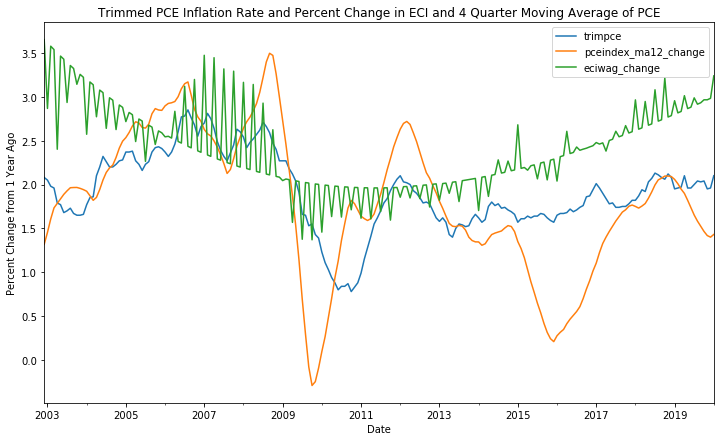

In [7]:
ax = labor2[['trimpce', 'pceindex_ma12_change', 'eciwag_change']].plot(figsize=(12,7),
                    title='Trimmed PCE Inflation Rate and Percent Change in ECI and 4 Quarter Moving Average of PCE') 
ax.autoscale(axis='x',tight=True)
# graphs show that epop and eciwag are diverging
ax.set(ylabel='Percent Change from 1 Year Ago'); 

In [8]:
labor2[['trimpce', 'pceindex_ma12_change', 'eciwag_change']].describe()

,trimpce,pceindex_ma12_change,eciwag_change
count,206.000000,206.000000,206.000000
mean,1.917184,1.817430,2.415265
std,0.438982,0.796595,0.485032
min,0.780000,-0.290112,1.369863
25%,1.660000,1.421090,2.032376
50%,1.885000,1.819367,2.344783
75%,2.230000,2.435619,2.763226
max,2.850000,3.495174,3.651271


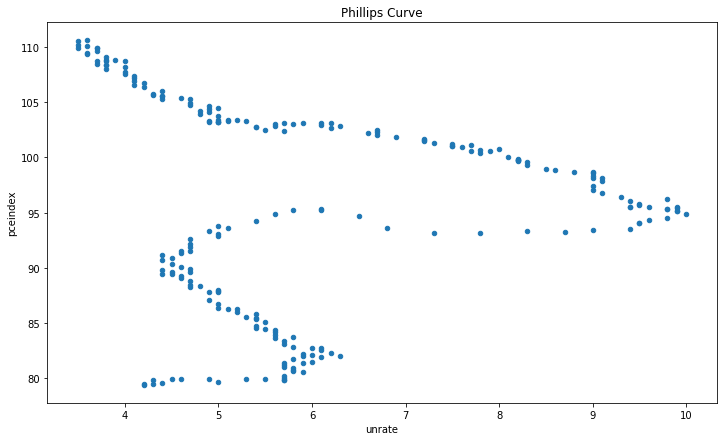

In [9]:
labor1.plot.scatter(x='unrate',y='pceindex', figsize=(12,7), title='Phillips Curve');

In [10]:
labor2[['unrate', 'pceindex', 'trimpce', 'eciwag', 'lmci', 'pepop', 'pceindex_ma12']].corr()

,unrate,pceindex,trimpce,eciwag,lmci,pepop,pceindex_ma12
unrate,1.000000,-0.178966,-0.566054,-0.272199,0.039743,-0.897570,-0.166800
pceindex,-0.178966,1.000000,-0.302210,0.986320,0.403634,-0.162154,0.998356
trimpce,-0.566054,-0.302210,1.000000,-0.282430,-0.518894,0.731775,-0.316733
eciwag,-0.272199,0.986320,-0.282430,1.000000,0.385414,-0.059758,0.986052
lmci,0.039743,0.403634,-0.518894,0.385414,1.000000,-0.309663,0.383919
pepop,-0.897570,-0.162154,0.731775,-0.059758,-0.309663,1.000000,-0.176441
pceindex_ma12,-0.166800,0.998356,-0.316733,0.986052,0.383919,-0.176441,1.000000


In [55]:
# regress unemployment rate on the 4 quarter moving average of PCE: Chain type price index inflation rate 
# check the relationship in the Phillips Curve
import statsmodels.api as sm # import statsmodels 
X = labor3['unrate_diff']
y = labor3['pceindex_ma12_change']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     pceindex_ma12_change   R-squared:                       0.026
Model:                              OLS   Adj. R-squared:                  0.021
Method:                   Least Squares   F-statistic:                     5.325
Date:                  Mon, 22 Jun 2020   Prob (F-statistic):             0.0220
Time:                          18:41:56   Log-Likelihood:                -241.41
No. Observations:                   205   AIC:                             486.8
Df Residuals:                       203   BIC:                             493.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8291      0.055     33.086      0.000       1.720       1.938
unrate_diff     0.7860      0.341      2.308      0.022       0.114       1.458
==============================================================================
Omnibus:                        7.198   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.387
Skew:                          -0.464   Prob(JB):                       0.0249
Kurtosis:                       2.937   Cond. No.                         6.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# regress unemployment rate on trimmed mean PCE 
# check the relationship in the Phillips Curve

X = labor3['unrate_diff']
y = labor3['trimpce_diff']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trimpce_diff   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     10.40
Date:                Mon, 22 Jun 2020   Prob (F-statistic):            0.00147
Time:                        18:43:12   Log-Likelihood:                 245.13
No. Observations:                 205   AIC:                            -486.3
Df Residuals:                     203   BIC:                            -479.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0011      0.005     -0.214      0.831      -0.011       0.009
unrate_diff    -0.1023      0.032     -3.225      0.001      -0.165      -0.040
==============================================================================
Omnibus:                        0.645   Durbin-Watson:                   1.165
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.350
Skew:                           0.017   Prob(JB):                        0.840
Kurtosis:                       3.200   Cond. No.                         6.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# regress labor market conditions index on trimmed mean PCE 
# check the relationship in the Phillips Curve
import statsmodels.api as sm # import statsmodels 
X = labor3['lmci']
y = labor3['trimpce_diff']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trimpce_diff   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     11.40
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           0.000879
Time:                        18:43:42   Log-Likelihood:                 245.61
No. Observations:                 205   AIC:                            -487.2
Df Residuals:                     203   BIC:                            -480.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0056      0.005     -1.033      0.303      -0.016       0.005
lmci           0.0277      0.008      3.377      0.001       0.012       0.044
==============================================================================
Omnibus:                        1.137   Durbin-Watson:                   1.211
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.817
Skew:                           0.122   Prob(JB):                        0.665
Kurtosis:                       3.191   Cond. No.                         1.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# regress labor market conditions index on trimmed mean PCE 
# check the relationship in the Phillips Curve
import statsmodels.api as sm # import statsmodels 
X = labor3['pepop_diff']
y = labor3['trimpce_diff']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trimpce_diff   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.127
Date:                Mon, 22 Jun 2020   Prob (F-statistic):             0.0435
Time:                        18:44:11   Log-Likelihood:                 242.07
No. Observations:                 205   AIC:                            -480.1
Df Residuals:                     203   BIC:                            -473.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.005     -0.065      0.948      -0.011       0.010
pepop_diff     0.0563      0.028      2.031      0.044       0.002       0.111
==============================================================================
Omnibus:                        0.673   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.372
Skew:                           0.011   Prob(JB):                        0.830
Kurtosis:                       3.208   Cond. No.                         5.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# regress labor market conditions index on trimmed mean PCE 
# check the relationship in the Phillips Curve
 
X = labor3['pepop_diff']
y = labor3['eciwag_change_diff']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     eciwag_change_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.08014
Date:                Mon, 22 Jun 2020   Prob (F-statistic):              0.777
Time:                        18:45:30   Log-Likelihood:                -97.904
No. Observations:                 205   AIC:                             199.8
Df Residuals:                     203   BIC:                             206.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.027     -0.062      0.951      -0.056       0.052
pepop_diff    -0.0412      0.145     -0.283      0.777      -0.328       0.246
==============================================================================
Omnibus:                       12.381   Durbin-Watson:                   2.969
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               30.183
Skew:                          -0.098   Prob(JB):                     2.79e-07
Kurtosis:                       4.870   Cond. No.                         5.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

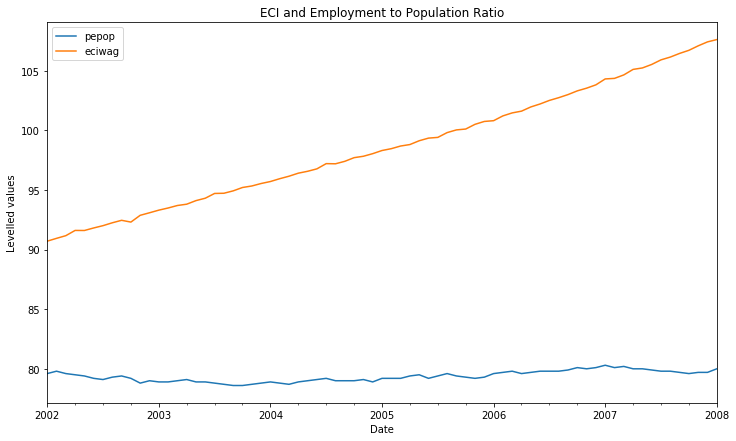

In [131]:
ax = labor1[['pepop', 'eciwag']].plot(figsize=(12,7), 
                        title='ECI and Employment to Population Ratio') # xlim=['2003-02-28','2020-03-31']

ax.autoscale(axis='x',tight=True)
ax.set(ylabel='Levelled values'); # graphs show that epop and eciwag are diverging

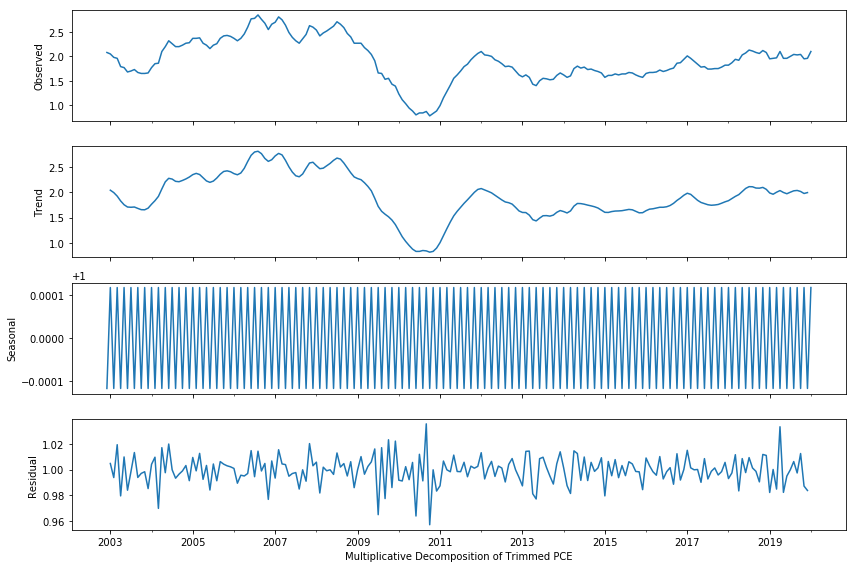

In [107]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 12,8 

result = seasonal_decompose(labor2['trimpce'], model='multiplicative', freq=2)

result.plot()
plt.xlabel("Multiplicative Decomposition of Trimmed PCE")
pyplot.show()

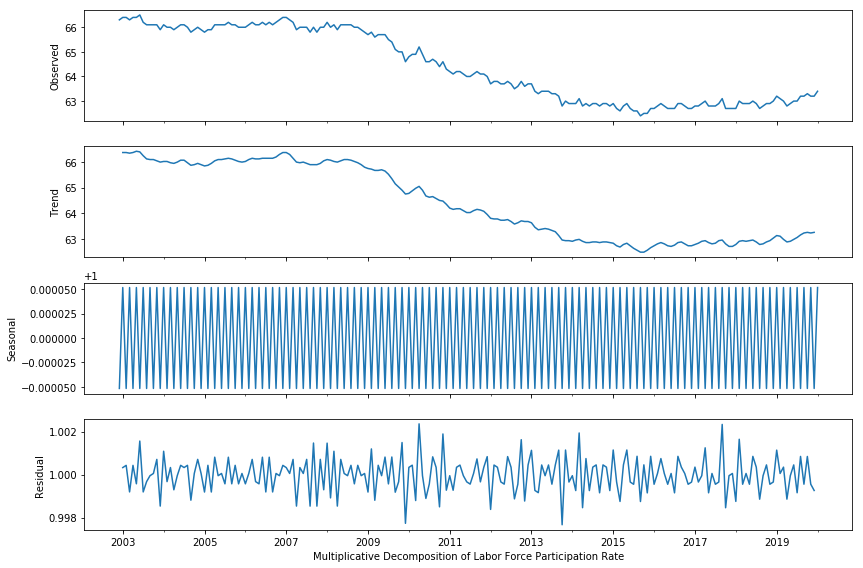

In [108]:
result = seasonal_decompose(labor2['lfpr'], model='multiplicative', freq=2)

result.plot()
plt.xlabel("Multiplicative Decomposition of Labor Force Participation Rate")
pyplot.show()

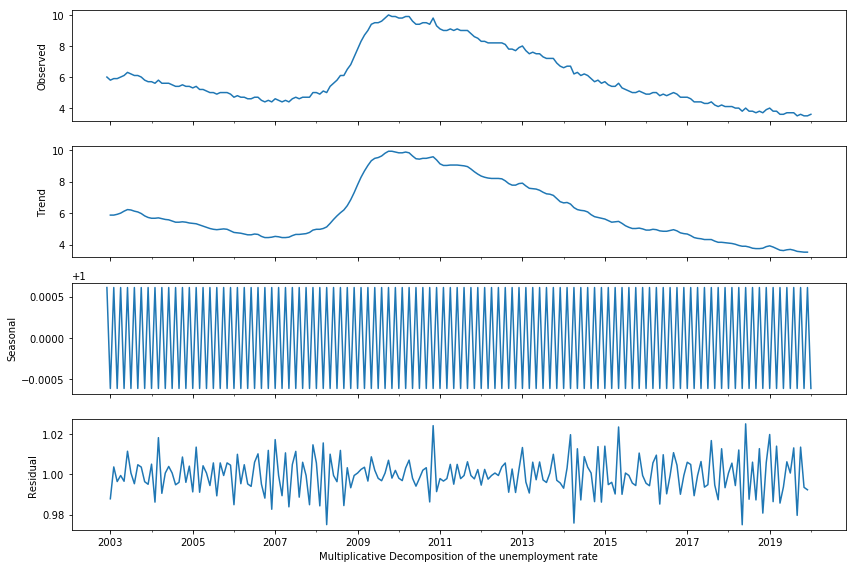

In [109]:
result = seasonal_decompose(labor2['unrate'], model='multiplicative', freq=2)

result.plot()
plt.xlabel("Multiplicative Decomposition of the unemployment rate")
pyplot.show()

## Johansen Test of Cointegration

Ho:there is no cointegration,
Ha: there is cointegrating relationship. 

If the p-value is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.

Below, the p-value of 0.966 is extremely large, so we fail to reject the null hypothesis and conclude that there is no cointegrating relationship between the variables - pceindex_ma12 and unrate

In [22]:
result = coint(labor2['pceindex_ma12'],labor2['unrate'])
result

(-0.46125140051878993,
 0.9669785503803419,
 array([-3.95066169, -3.36609772, -3.0652035 ]))

In [64]:
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS


tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r




def coint_johansen(x, p, k, print_on_console=True):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print ('--------------------------------------------------')
        print ('--> Trace Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print ('r =', i, '\t', round(result.lr1[i], 4), result.cvt[i, 0], result.cvt[i, 1], result.cvt[i, 2])
        print ('--------------------------------------------------')
        print ('--> Eigen Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print ('r =', i, '\t', round(result.lr2[i], 4), result.cvm[i, 0], result.cvm[i, 1], result.cvm[i, 2])
        print ('--------------------------------------------------')
        print ('eigenvectors:\n', result.evec)
        print ('--------------------------------------------------')
        print ('eigenvalues:\n', result.eig)
        print ('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc


In [68]:
result = coint_johansen(labor2[['pepop', 'unrate']],p=1, k=1)

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 24.6527 16.1619 18.3985 23.1485
r = 1 	 6.6239 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 18.0288 15.0006 17.1481 21.7465
r = 1 	 6.6239 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[-2.11532088 -0.6246716 ]
 [-2.09725284 -0.04131285]]
--------------------------------------------------
eigenvalues:
 [0.08458398 0.03194865]
--------------------------------------------------


After checking for unit root,I found that:
1. the series (from Dec 2001-Jan 2008) are integrated of order 1 i.e. statonary after first difference
2. pepop is I(1), and unrate is I(0) if the series ranges from Jan 1948 - Jan 2008

In case 1, I have performed a cointegration test to establish a long run relationship. This implies that we can assume a long run relationship in the model even if the series are drifting apart or trending either upwards or downwards. 

In the Johansen Cointegration Test:
Ho = no cointegration equation
H1 = series are cointegrated

Cointegration test should be performed on the level form of the variables and not on their first difference and it is ok to use log transformation of the raw variables

=> reject Ho if the value of the trace and max eigen statistics > 0.05 critical value

when r = 0 => no cointegration equations in the model.
Here, the trace stat : 24.6527 > 18.3985(critical value at 0.05 level) => rejects the Ho that there is no cointergation relation in the model. Thus, unrate and pepop have no cointegration relationship.

when r=1,there is at most 1 cointegration equation in the model
Here, the trace stat : 6.6239 < 6.6349 (critical value at 0.001 level) => fail to reject the Ho that there is at most 1 cointergation relation in the model. Thus, unrate and pepop have at most 1 cointegration relationship.

If the series are cointegrated, they exibit long run relationship and can be combined linearly. 
=> even if there are shocks in the short run, which may affect the movement in the individual series, they would converge with time in the long run => estimate both short and long run models. 

So, even though both unrate and pepop are non-stationary is Y_t - beta*X_t  stationary as it as both unrate and pepop are cointegrated and I(1) => Can regress Y_t on X_t. 



In [60]:
y = labor['pepop']
X = labor['unrate']
X = sm.add_constant(X) ## add an intercept (beta_0) to the model


model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X) 

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pepop   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     785.0
Date:                Mon, 22 Jun 2020   Prob (F-statistic):           1.25e-75
Time:                        18:47:23   Log-Likelihood:                -288.08
No. Observations:                 229   AIC:                             580.2
Df Residuals:                     227   BIC:                             587.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         83.3240      0.196    425.956      0.000      82.939      83.709
unrate        -0.8789      0.031    -28.018      0.000      -0.941      -0.817
==============================================================================
Omnibus:                       68.431   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.739
Skew:                          -0.166   Prob(JB):                      0.00171
Kurtosis:                       1.893   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When unrate increases by 1 percent, peop decreases by 0.65 percent